## INTRODUCTION

Recommendation system is an information filtering system that seeks to predict the rating or the preference a user might give to an item.In other words, it is an algorithm that suggests relevant items to users. It greatly influences with what we interact with the world. For instance, which movie to watch in Netflix, in e-commerce which product to buy, or in kindle which book to read, and many more.

Recommendation System is ubiquitous because of information overload and is growing in popularity in the world of predictive modelling and Machine Learning.To build a movie recommendation system is to provide recommendations to number of users with numerous movies. Recommendation is done based on similarity between users (Collaborative Filtering) or by considering particular user’s activity (Content Based Filtering) which he wants to engage with.

Solid updated data covering user behavior, product (movie) information, and the reviews that link them both is critical. 
Selecting efficient features as well implementation of advanced machine learning tools and algorithms are also instrumental.

Data Source: 
The dataset for this project was obtained from MovieLens, an online recommendation service. The dataset has two sub-datasets, first one is the ratings dataset which consists of around 25 million user ratings and the second one is the movies dataset which provides information about the movie name, genre and the year of release.


### Import the required libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import sys
from sklearn.model_selection import train_test_split
from surprise import Reader, Dataset, SVD, SlopeOne, NMF, SVDpp, KNNBaseline, CoClustering, accuracy
from surprise.model_selection import cross_validate
import time
from sklearn.preprocessing import MinMaxScaler
import implicit
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve

### Read the dataset

In [2]:
r = pd.read_csv("../joshm/ratings.csv")
r.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


### Ratings Dataset: Rows and Columns

In [3]:
r.shape

(25000095, 4)

The ratings dataset has around 25 million ratings observations (rows) and 4 variables (columns)

In [4]:
r.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [5]:
r.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [6]:
r.rating.value_counts()

4.0    6639798
3.0    4896928
5.0    3612474
3.5    3177318
4.5    2200539
2.0    1640868
2.5    1262797
1.0     776815
1.5     399490
0.5     393068
Name: rating, dtype: int64

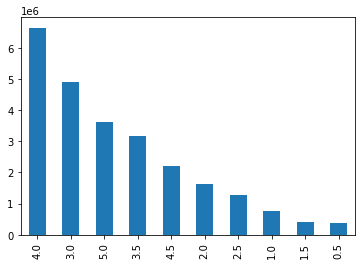

In [7]:
p=r.rating.value_counts().plot(kind="bar")

In [8]:
movies = pd.read_csv("../joshm/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
movies.shape

(62423, 3)

In [10]:
movies.columns

Index(['movieId', 'title', 'genres'], dtype='object')

In [11]:
movies.dtypes

movieId     int64
title      object
genres     object
dtype: object

### DATA WRANGLING

In [12]:
movies['genres'] = movies['genres'].str.split('|')
movies['year']=movies['title'].str[-5:-1]
movies=movies[(movies['title'].str[-1]==')')&(movies['title'].str[-6]=='(')] #drop the movies without year in title
movies.year=pd.to_numeric(movies.year)
movies['Decade']=movies['year']//10 *10
movies=movies.set_index('movieId')
movies.sort_values('year').head() 

,title,genres,year,Decade
movieId,,,,
148054,Passage de Venus (1874),[Documentary],1874,1870
148048,Sallie Gardner at a Gallop (1878),[(no genres listed)],1878,1870
202045,Athlete Swinging a Pick (1880),[Documentary],1880,1880
166800,Buffalo Running (1883),[(no genres listed)],1883,1880
148040,Man Walking Around a Corner (1887),[(no genres listed)],1887,1880


### Separating the 'Genres' column 

In [13]:
sep = movies.reset_index().set_index(['movieId','title','year'])['genres'].apply(pd.Series).stack()
sep = sep.reset_index()
sep.columns=['movieId','title','year','level','genres']
sep.to_csv('sep.csv')
print('Available Genres: ',sep.genres.unique())
sep.head()

Available Genres:  ['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'IMAX'
 'Documentary' 'War' 'Musical' 'Western' 'Film-Noir' '(no genres listed)']


,movieId,title,year,level,genres
0,1,Toy Story (1995),1995,0,Adventure
1,1,Toy Story (1995),1995,1,Animation
2,1,Toy Story (1995),1995,2,Children
3,1,Toy Story (1995),1995,3,Comedy
4,1,Toy Story (1995),1995,4,Fantasy


## Exploratory Data Analysis(EDA) 

In [14]:
df = pd.merge(r,movies,on='movieId')
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
"""BLOW THE NIGHT!"" Let's Spend the Night Together (1983)",3.000000,1
"""Great Performances"" Cats (1998)",2.896648,179
#1 Cheerleader Camp (2010),2.111111,9
#Captured (2017),3.750000,2
#Female Pleasure (2018),3.666667,3


In [15]:
df.head()

,userId,movieId,rating,timestamp,title,genres,year,Decade
0,1,296,5.0,1147880044,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]",1994,1990
1,3,296,5.0,1439474476,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]",1994,1990
2,4,296,4.0,1573938898,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]",1994,1990
3,5,296,4.0,830786155,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]",1994,1990
4,7,296,4.0,835444730,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]",1994,1990


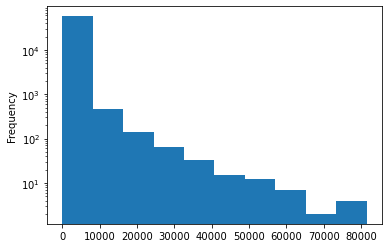

In [16]:
ratings['num of ratings'].plot(logy=True, kind='hist')
plt.show()

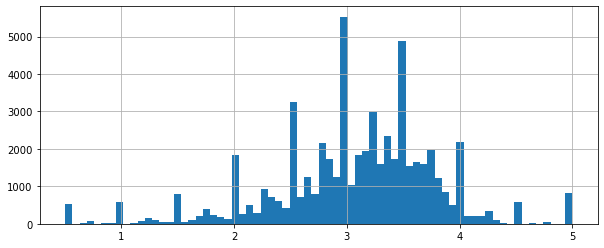

In [17]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)
plt.show()

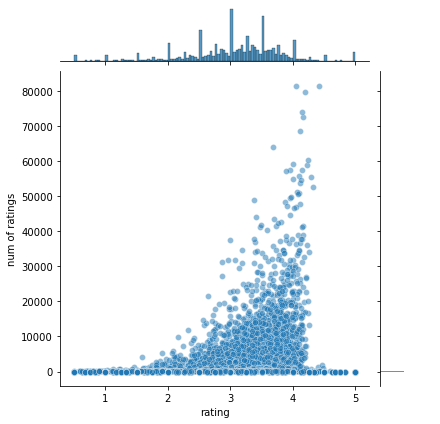

In [18]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)
plt.show()

### Total number of movies of each Genre

Drama, Comedy, and Thriller have the most production.

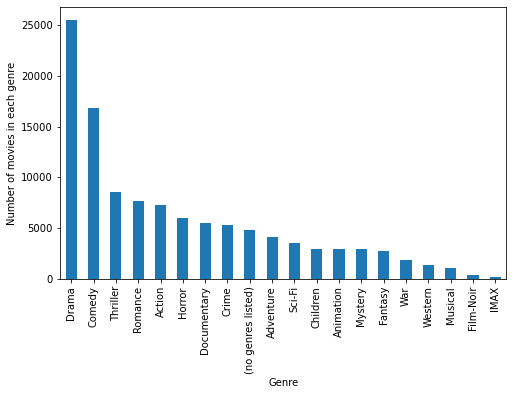

In [19]:
plt.figure(figsize=(8,5))
sep['genres'].value_counts().plot(kind='bar')
plt.ylabel('Number of movies in each genre')
plt.xlabel('Genre')
plt.show()

### Total number of movies in each decade

Most production was in 2010 decade.

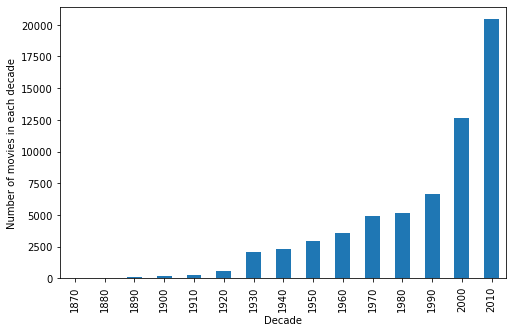

In [20]:
plt.figure(figsize=(8,5))
movies['Decade'].value_counts().sort_index().plot(kind='bar') 
plt.xlabel('Decade')
plt.ylabel('Number of movies in each decade')
plt.show()

### Years with most Drama genre:

Most drama movies produced in 2014, 2015, and 2016 respectively.

In [21]:
sep[sep['genres']=='Drama']['year'].value_counts().head(3) 

2015    926
2014    909
2016    891
Name: year, dtype: int64

### Number of drama movies in each decade.

Most drama movies produced in decade 2010 

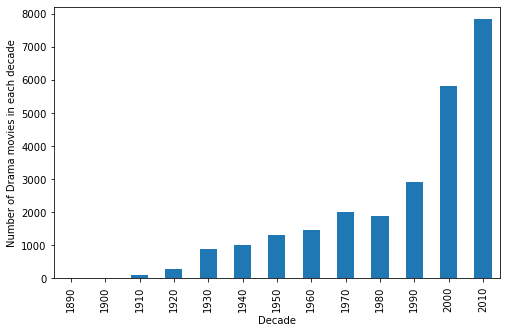

In [22]:
plt.figure(figsize=(8,5))
sep['Decade']=sep['year']//10 *10
sep[sep['genres']=='Drama']['Decade'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Decade')
plt.ylabel('Number of Drama movies in each decade')
plt.show()

### Movies with same title including the year are:

98 movies are with same title.

In [23]:
sum(movies['title'].value_counts()>1)

98

### Movies repeated twice including the year are:

In [24]:
movies['title'].value_counts().head(16)

Seven Years Bad Luck (1921)                                                     2
Truth (2015)                                                                    2
Operator (2015)                                                                 2
Forsaken (2016)                                                                 2
Blockbuster (2017)                                                              2
Paradise (2013)                                                                 2
Ecstasy (2011)                                                                  2
The Lonely Island Presents: The Unauthorized Bash Brothers Experience (2019)    2
Beats (2019)                                                                    2
The Forest (2016)                                                               2
Delirium (2018)                                                                 2
Another World (2014)                                                            2
Weekend (2011)  

### Movie titles (excluding the year in the title) repeated several times are: 

In [25]:
movies['Name']=movies['title'].str[:-7] #removing the year from title
movies['Name'].value_counts().head(20) 

Cinderella               16
First Love                9
Hamlet                    9
Home                      9
Aurora                    8
Treasure Island           8
Misérables, Les           8
Wuthering Heights         8
Stranded                  8
Revenge                   8
The Escape                8
Three Musketeers, The     7
The Forest                7
Trapped                   7
Heidi                     7
Macbeth                   7
Alice in Wonderland       7
Countdown                 7
Captive                   7
Underground               7
Name: Name, dtype: int64

### 8 movies have been produced with the title 'Hamlet'.
The following barplot shows the number of 'Hamlet' movies in each decade.

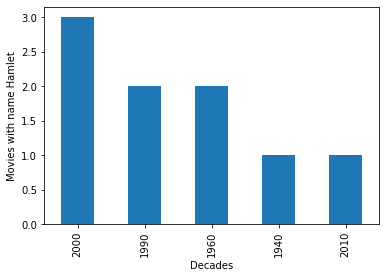

In [26]:
movies[movies.Name=='Hamlet'].sort_values(by='Decade').Decade.value_counts().plot(kind='bar')
plt.xlabel('Decades')
plt.ylabel('Movies with name Hamlet')
plt.show()

### 9 movies has been produced with title 'Misérables, Les'. 
The following barplot shows the number of 'Misérables, Les' movies in each decade.

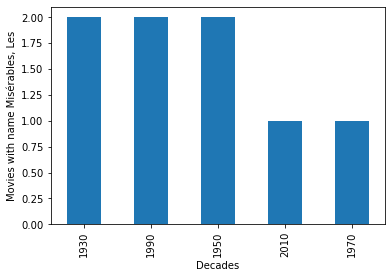

In [27]:
movies[movies.Name=='Misérables, Les'].sort_values(by='Decade').Decade.value_counts().plot(kind='bar')
plt.xlabel('Decades')
plt.ylabel('Movies with name Misérables, Les')
plt.show()

In [28]:
r.rating.value_counts()

4.0    6639798
3.0    4896928
5.0    3612474
3.5    3177318
4.5    2200539
2.0    1640868
2.5    1262797
1.0     776815
1.5     399490
0.5     393068
Name: rating, dtype: int64

In [29]:
List=[]
for i in np.arange(4,5.5, 0.5):
    M=movies.loc[r[r.rating==i].movieId.value_counts().head(10).index,'title']
    print('Rate: %f' %i)
    print(M)
    print(' ')

Rate: 4.000000
593              Silence of the Lambs, The (1991)
356                           Forrest Gump (1994)
480                          Jurassic Park (1993)
457                          Fugitive, The (1993)
296                           Pulp Fiction (1994)
589             Terminator 2: Judgment Day (1991)
2571                           Matrix, The (1999)
1                                Toy Story (1995)
318              Shawshank Redemption, The (1994)
260     Star Wars: Episode IV - A New Hope (1977)
Name: title, dtype: object
 
Rate: 4.500000
318                       Shawshank Redemption, The (1994)
2571                                    Matrix, The (1999)
2959                                     Fight Club (1999)
296                                    Pulp Fiction (1994)
4993     Lord of the Rings: The Fellowship of the Ring,...
356                                    Forrest Gump (1994)
593                       Silence of the Lambs, The (1991)
7153     Lord of the Rings: 

### Average rating for the Shawshank Redemption is:

In [30]:
r[r.movieId==318].rating.mean()  #Average rating for the 'Shawshank Redemption, The'

4.413576004516335

### Average rating for the Pulp Fiction is:

In [31]:
r[r.movieId==296].rating.mean() #Average rating for 'Pulp Fiction' 


4.188912039361382

### The movies with the max number of ratings are:

Pulp Fiction, Forrest Gump, Shawshank redemption respectively.

In [32]:
MaxRating=r['movieId'].value_counts().head(10)

In [33]:
movies.loc[MaxRating.index,'title'] 

356                           Forrest Gump (1994)
318              Shawshank Redemption, The (1994)
296                           Pulp Fiction (1994)
593              Silence of the Lambs, The (1991)
2571                           Matrix, The (1999)
260     Star Wars: Episode IV - A New Hope (1977)
480                          Jurassic Park (1993)
527                       Schindler's List (1993)
110                             Braveheart (1995)
2959                            Fight Club (1999)
Name: title, dtype: object

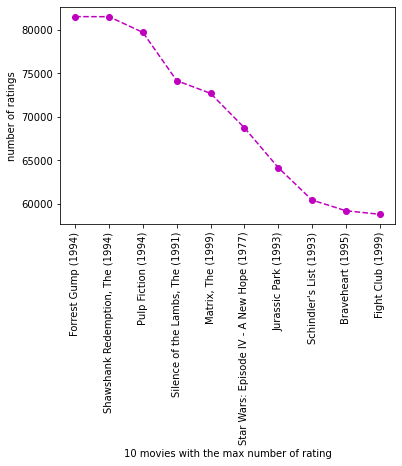

In [34]:
plt.plot(range(len(MaxRating)), MaxRating,'mo--')
plt.xticks(range(len(MaxRating)), movies.loc[MaxRating.index,'title'],rotation=90)
plt.xlabel('10 movies with the max number of rating')
plt.ylabel('number of ratings')
plt.savefig('foo4.png',dpi=300,bbox_inches='tight')
plt.show()

### The movies with the highest average rating are:

Pulp Fiction, Forrest Gump, Shawshank redemption respectively

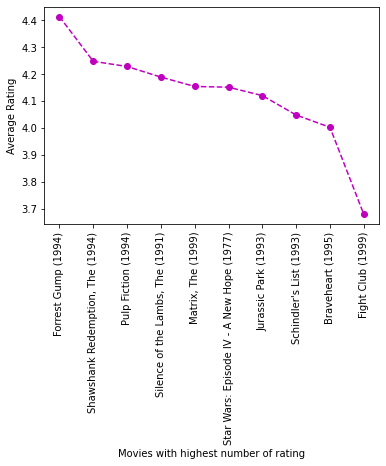

In [35]:
List5=[]
for i in MaxRating.index:
    List5.append(r[r.movieId==i].rating.mean())
plt.plot(range(len(List5)), sorted(List5,reverse=True),'mo--')
plt.xticks(range(len(List5)), movies.loc[MaxRating.index,'title'],rotation=90)
plt.xlabel('Movies with highest number of rating')
plt.ylabel('Average Rating')
plt.show()

### Merge movie and rating data frames

In [36]:
r1= r.merge(sep.reset_index(), left_on='movieId', right_on='movieId', how='inner')
del r1['timestamp']
r1.head() #merge sep and rating

,userId,movieId,rating,index,title,year,level,genres,Decade
0,1,296,5.0,612,Pulp Fiction (1994),1994,0,Comedy,1990
1,1,296,5.0,613,Pulp Fiction (1994),1994,1,Crime,1990
2,1,296,5.0,614,Pulp Fiction (1994),1994,2,Drama,1990
3,1,296,5.0,615,Pulp Fiction (1994),1994,3,Thriller,1990
4,3,296,5.0,612,Pulp Fiction (1994),1994,0,Comedy,1990


### Boxplot of 'Decade' vs 'Rating'

Movies of 40th decade has the highest rating

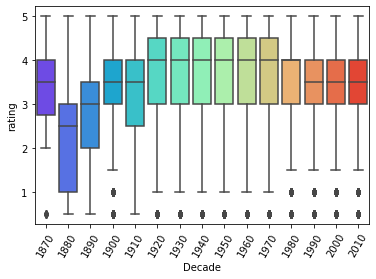

In [37]:
sns.boxplot(x='Decade', y='rating', data=r1,palette='rainbow')
plt.xticks(rotation=60)
plt.show()

In [38]:
df.head()

,userId,movieId,rating,timestamp,title,genres,year,Decade
0,1,296,5.0,1147880044,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]",1994,1990
1,3,296,5.0,1439474476,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]",1994,1990
2,4,296,4.0,1573938898,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]",1994,1990
3,5,296,4.0,830786155,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]",1994,1990
4,7,296,4.0,835444730,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]",1994,1990


### Boxplot of the 'Decade' vs 'Genres'

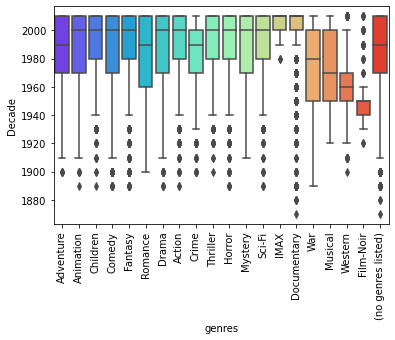

In [39]:
sns.boxplot(x='genres', y='Decade', data=sep,palette='rainbow')
plt.xticks(rotation=90)
plt.show()

### Average rating of the ppl with highest number of rating

In [40]:
ID=r1.userId.value_counts().head(10) #UserID wih highest number of rating
List5=[]
for i in ID.index:
    List5.append(r1[r1.userId==i]['rating'].mean())

List5


[3.059529475759842,
 3.293543582104885,
 3.1621777103707966,
 2.588408644400786,
 3.2133722717491544,
 1.5864336965187351,
 2.7965700965700964,
 3.4570232095961386,
 2.4856424148606813,
 3.752986012887003]

### Boxplot of the 'Genre' vs 'Rating'

<function matplotlib.pyplot.show(close=None, block=None)>

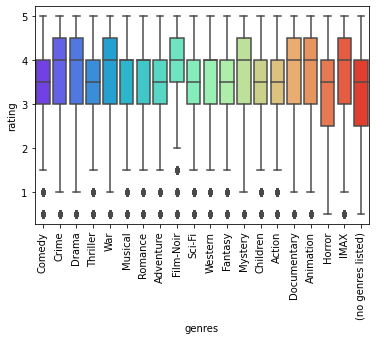

In [41]:
sns.boxplot(x='genres', y='rating', data=r1,palette='rainbow')
plt.xticks(rotation=90)
plt.show

### CORRELATION MATRIX

The correlation matrix shows there is no correlation

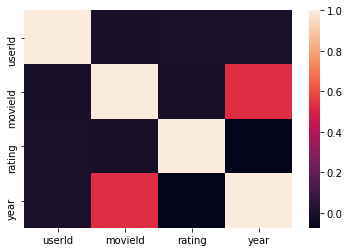

In [42]:
sns.heatmap(r1[['userId','movieId','rating','year']].corr())
plt.show()

### WORD CLOUD

Word cloud for Titles : The most common word used in movie titles is "Love".

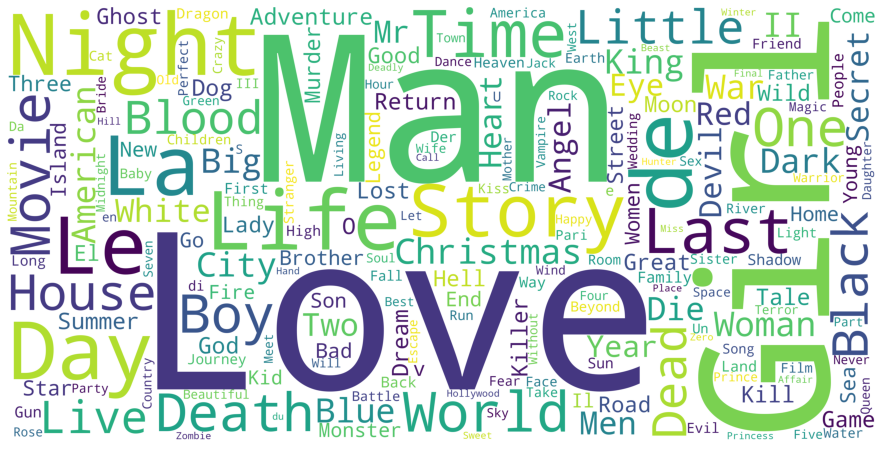

In [43]:
movies['title'] = movies['title'].astype('str')

title_corpus = ' '.join(movies['title'])


title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

### MISSING VALUES

In [44]:
df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
year         0
Decade       0
dtype: int64

It was observed that there are no missing values in the dataset.

### PRE-PROCESSING

In [45]:
# Drop the column 'timestamp'
movielens=r.drop(['timestamp'], axis=1)

In [46]:
movielens.head()

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [47]:
#user id with more than 100 votings
movielens=movielens.iloc[(r.userId.value_counts()>100).index,:]

In [48]:
movielens.head()

,userId,movieId,rating
72315,554,589,4.0
80974,619,127096,3.5
137293,973,6874,4.0
33844,256,3534,3.0
20055,166,1453,2.0


### Train-Test Split

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(movielens[['userId','movieId']],movielens['rating'],test_size=0.30, 
                                                  random_state= 47)

y_train=pd.DataFrame(y_train)
train=X_train.join(y_train)

y_test=pd.DataFrame(y_test)
test=X_test.join(y_test)

In [50]:
r1=r1[['userId','movieId','rating','title','genres']]
r1.head()

,userId,movieId,rating,title,genres
0,1,296,5.0,Pulp Fiction (1994),Comedy
1,1,296,5.0,Pulp Fiction (1994),Crime
2,1,296,5.0,Pulp Fiction (1994),Drama
3,1,296,5.0,Pulp Fiction (1994),Thriller
4,3,296,5.0,Pulp Fiction (1994),Comedy


### 1. SIMPLE RECOMMENDER

In [51]:
a=r1[r1.genres=='Drama'].movieId.value_counts().head(30).index
count=0
for i in a:
    if (r1[(r1.movieId==i)].rating.mean()>4.1)&(count<10):
        count+=1
        print(count,':',r1[(r1.genres=='Drama')&(r1.movieId==i)].title.iloc[0])

1 : Shawshank Redemption, The (1994)
2 : Pulp Fiction (1994)
3 : Schindler's List (1993)
4 : Fight Club (1999)
5 : American Beauty (1999)
6 : Godfather, The (1972)
7 : Fargo (1996)
8 : Dark Knight, The (2008)
9 : Inception (2010)
10 : One Flew Over the Cuckoo's Nest (1975)


In [52]:
a=r1[r1.genres=='Romance'].movieId.value_counts().head(30).index
count=0
for i in a:
    if (r1[(r1.movieId==i)].rating.mean()>3.5)&(count<10):
        count+=1
        print(count,':',r1[(r1.genres=='Romance')&(r1.movieId==i)].title.iloc[0])

1 : Forrest Gump (1994)
2 : American Beauty (1999)
3 : Shrek (2001)
4 : Good Will Hunting (1997)
5 : Princess Bride, The (1987)
6 : Groundhog Day (1993)
7 : Beauty and the Beast (1991)
8 : Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)
9 : Eternal Sunshine of the Spotless Mind (2004)
10 : Beautiful Mind, A (2001)


In [53]:
a=r1[r1.genres=='Action'].movieId.value_counts().head(30).index
count=0
for i in a:
    if (r1[(r1.movieId==i)].rating.mean()>4)&(count<10):
        count+=1
        print(count,':',r1[(r1.genres=='Action')&(r1.movieId==i)].title.iloc[0])

1 : Matrix, The (1999)
2 : Star Wars: Episode IV - A New Hope (1977)
3 : Braveheart (1995)
4 : Fight Club (1999)
5 : Star Wars: Episode V - The Empire Strikes Back (1980)
6 : Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
7 : Lord of the Rings: The Return of the King, The (2003)
8 : Saving Private Ryan (1998)
9 : Dark Knight, The (2008)
10 : Inception (2010)


### 2. IMDB

In [54]:
C=r1.groupby('movieId').rating.mean().mean()
m=r1.movieId.value_counts().quantile(0.95)
print(' mean vote across the whole report (C):',C)
print('minimum votes required to be listed in the chart (m):',m)

 mean vote across the whole report (C): 3.0713432976030273
minimum votes required to be listed in the chart (m): 3360.0999999999913


In [55]:
a=r1.movieId.value_counts().sort_index()
b=r1.groupby('movieId').rating.mean()

In [56]:
print('Number of Movies which are qualified:',sum((a>m)&(b>C)))

Number of Movies which are qualified: 2307


In [57]:
a=pd.DataFrame(a.values,columns=['counts'],index=a.index)
b=pd.DataFrame(b.values,columns=['mean'],index=b.index)

In [58]:
df=pd.concat([a,b], axis=1, sort=False)
qualified = df[(df['counts'] >= m)  & (df['mean']>=C)]

print(qualified.shape[0],' movies are qualified')

2307  movies are qualified


In [59]:
def weighted_rating(x):
    v = x['counts']
    R = x['mean']
    return (v/(v+m) * R) + (m/(m+v) * C)

qualified['wr'] = qualified.apply(weighted_rating, axis=1)
qualified = qualified.sort_values('wr', ascending=False)

List1=[]
for i in qualified.head(30).index:
    List1.append(movies[movies.index==i]['title'].values)
IMDBBest=pd.DataFrame(List1,columns=['Best to Recommend'])
IMDBBest

<ipython-input-59-36cfdb13e9c8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['wr'] = qualified.apply(weighted_rating, axis=1)


,Best to Recommend
0,"Shawshank Redemption, The (1994)"
1,"Godfather, The (1972)"
2,"Usual Suspects, The (1995)"
3,Schindler's List (1993)
4,Fight Club (1999)
5,"Godfather: Part II, The (1974)"
6,Pulp Fiction (1994)
7,Seven Samurai (Shichinin no samurai) (1954)
8,Spirited Away (Sen to Chihiro no kamikakushi) ...
9,North by Northwest (1959)


### 3. Content-based filtering

In [60]:
def evaluate(estimate_f):
    ids_to_estimate = zip(test.userId, test.movieId)
    estimated = np.array([estimate_f(u,i) for (u,i) in ids_to_estimate])
    real = y_test.values
    return np.sqrt(np.mean(np.power(estimated-real, 2)))

def content_mean(user_id, movie_id):
    user_condition = X_train.userId == user_id
    return y_train[user_condition].mean()

start = time.time()
print('RMSE for content base filtering is: %s' % round(evaluate(content_mean),4))
end = time.time()
print('Total elapsed time of content base filtering is:',round(end - start,3))

RMSE for content base filtering is: 0.9398
Total elapsed time of content base filtering is: 80.833


### Collaborative Filtering

### Simple collaborative filtering

In [61]:
def collab_mean(user_id, movie_id):
    user_condition = X_train.movieId == movie_id
    return y_train[user_condition].mean()

i=1
j=296
print('Collaborative mean filter for userId:',i, 'and movieId:', j, 'is:',collab_mean(i,j).values)
print('Actual rating value is:', r1[(r1.userId==i)&(r1.movieId==j)]['rating'].mean())
print('')

i=1
j=306
print('Collaborative mean filter for userId:',i, 'and movieId:', j, 'is:',collab_mean(i,j).values)
print('Actual rating value is:', r1[(r1.userId==i)&(r1.movieId==j)]['rating'].mean())
print('')



i=15830
j=899
print('Collaborative mean filter for userId:',i, 'and movieId:', j, 'is:',collab_mean(i,j).values)
print('Actual rating value is:', r1[(r1.userId==i)&(r1.movieId==j)]['rating'].mean())
print('')

Collaborative mean filter for userId: 1 and movieId: 296 is: [4.18286445]
Actual rating value is: 5.0

Collaborative mean filter for userId: 1 and movieId: 306 is: [4.11428571]
Actual rating value is: 3.5

Collaborative mean filter for userId: 15830 and movieId: 899 is: [3.96363636]
Actual rating value is: 4.0



### SVD

In [62]:
data = Dataset.load_from_df(movielens[['userId', 'movieId', 'rating']], Reader())

In [63]:
Models=[SVD(), NMF(), SlopeOne(), KNNBaseline(), CoClustering()]

for i in Models:
    start = time.time()
    cross_validate(i, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    end = time.time()
    print('Total Elapsed time with model is:',end - start)
    print(' ')
    print(' ')

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8659  0.8632  0.8695  0.8698  0.8731  0.8683  0.0034  
MAE (testset)     0.6641  0.6631  0.6647  0.6684  0.6688  0.6658  0.0023  
Fit time          7.92    7.92    8.00    7.94    7.98    7.95    0.03    
Test time         0.22    0.20    0.28    0.28    0.19    0.23    0.04    
Total Elapsed time with model is: 42.198639154434204
 
 
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9056  0.9040  0.9180  0.9057  0.9051  0.9077  0.0052  
MAE (testset)     0.6920  0.6928  0.7013  0.6952  0.6939  0.6951  0.0033  
Fit time          9.17    9.08    9.24    9.50    9.40    9.28    0.15    
Test time         0.28    0.28    0.16    0.28    0.17    0.23    0.06    
Total Elapsed time with model is: 48.80450797080994
 
 
Evaluating RMSE, MAE of algor

In [64]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.25, random_state=55)

Models=[SVD(), NMF(), SlopeOne(), KNNBaseline(), CoClustering()]
m=['SVD','NMF','Slop One','KNN Baseline', 'CoClustering']

count=0

for algo in Models:
    print(m[count])
    start = time.time()
    algo.fit(trainset)
    predictions = algo.test(testset)
    end = time.time()    
    print('Total Elapsed time with model is:',round(end - start,3)) 
    i=1
    j=296
    print('Prediction of a particular user:', algo.predict(i,j, 3).est)
    print('Actual rating value is:', r1[(r1.userId==i)&(r1.movieId==j)]['rating'].mean())
    print('')
    i=1
    j=306
    print('Prediction of a particular user:', algo.predict(i,j, 3).est)
    print('Actual rating value is:', r1[(r1.userId==i)&(r1.movieId==j)]['rating'].mean())
    print('')
    i=15830
    j=899
    print('Prediction of a particular user:', algo.predict(i,j, 3).est)
    print('Actual rating value is:', r1[(r1.userId==i)&(r1.movieId==j)]['rating'].mean())
    print('')
    print('')
    count+=1

SVD
Total Elapsed time with model is: 7.754
Prediction of a particular user: 4.239573810196679
Actual rating value is: 5.0

Prediction of a particular user: 4.482495981697261
Actual rating value is: 3.5

Prediction of a particular user: 4.163583872821172
Actual rating value is: 4.0


NMF
Total Elapsed time with model is: 8.766
Prediction of a particular user: 4.066905103260324
Actual rating value is: 5.0

Prediction of a particular user: 4.363328252771737
Actual rating value is: 3.5

Prediction of a particular user: 3.572232476108445
Actual rating value is: 4.0


Slop One


<ipython-input-64-c879d4b7cae6>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo.fit(trainset)


Total Elapsed time with model is: 14.784
Prediction of a particular user: 4.416777221694998
Actual rating value is: 5.0

Prediction of a particular user: 3.8768368205868207
Actual rating value is: 3.5

Prediction of a particular user: 3.572232476108445
Actual rating value is: 4.0


KNN Baseline
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Total Elapsed time with model is: 5.861
Prediction of a particular user: 4.428742992368232
Actual rating value is: 5.0

Prediction of a particular user: 4.265096680986866
Actual rating value is: 3.5

Prediction of a particular user: 4.1354490641094035
Actual rating value is: 4.0


CoClustering


<ipython-input-64-c879d4b7cae6>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo.fit(trainset)


Total Elapsed time with model is: 4.484
Prediction of a particular user: 4.498722710300424
Actual rating value is: 5.0

Prediction of a particular user: 4.446344570842262
Actual rating value is: 3.5

Prediction of a particular user: 3.572232476108445
Actual rating value is: 4.0




### Hyperparameter Tuning

In [65]:
from surprise.model_selection import GridSearchCV

grid = {'n_epochs': [5, 10, 20, 30], 
        'lr_all': [.0025, .005, .001, .01]}

gs = GridSearchCV(SVD, grid, measures=['MAE'], cv=5)
gs.fit(data)

print(gs.best_score['mae'])
print(gs.best_params['mae'])

0.6651475194004115
{'n_epochs': 10, 'lr_all': 0.01}


### SVD++

In [66]:
from surprise import SVDpp

clf = SVDpp()
cross_validate(clf, data, measures=['MAE'], cv=5, verbose=False)

{'test_mae': array([0.65199117, 0.65593568, 0.65735316, 0.65093761, 0.65176655]),
 'fit_time': (711.7053055763245,
  702.100403547287,
  703.9933023452759,
  705.8532741069794,
  704.980532169342),
 'test_time': (10.608460903167725,
  10.797223567962646,
  10.655621767044067,
  11.24951982498169,
  10.529500007629395)}

### Alternative Least Squares(ALS) Collaborative Filtering

In [67]:
data=movielens
sparse_item_user = sparse.csr_matrix((data['rating'].astype(float), (data['movieId'], data['userId'])))
sparse_user_item = sparse.csr_matrix((data['rating'].astype(float), (data['userId'], data['movieId'])))

# Initializing the als model and fitting it using the sparse item-user matrix.
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)

# Calculating the confidence by multiplying with the alpha value.
alpha_val = 15
data_conf = (sparse_item_user * alpha_val).astype('double')

model.fit(data_conf)

  0%|          | 0/20 [00:00<?, ?it/s]

### Recommending movies to the user_id # 1

In [68]:
# Creating recommendations for user-id# 1
user_id =1

# Use the implicit recommender.
recommended = model.recommend(user_id, sparse_user_item)

movies = []
scores = []
c=[]

for item in recommended:
    idx, score=item
    movies.append(data.movieId.loc[data.movieId==idx].iloc[0])
    scores.append(score)


recommendations = pd.DataFrame({'MovieId': movies, 'Score': scores})

for i in movies:
    c.append(r1[r1.movieId==i].title.iloc[0])
recommendations['Title']=c
recommendations

,MovieId,Score,Title
0,3083,1.134779,All About My Mother (Todo sobre mi madre) (1999)
1,2067,1.115672,Doctor Zhivago (1965)
2,1293,1.108324,Gandhi (1982)
3,27815,1.098563,"Chorus, The (Choristes, Les) (2004)"
4,1251,1.089487,8 1/2 (8½) (1963)
5,5618,1.081290,Spirited Away (Sen to Chihiro no kamikakushi) ...
6,6350,1.072174,Laputa: Castle in the Sky (Tenkû no shiro Rapy...
7,5971,1.070637,My Neighbor Totoro (Tonari no Totoro) (1988)
8,8638,1.046148,Before Sunset (2004)
9,3328,1.041340,Ghost Dog: The Way of the Samurai (1999)


### Recommending movies to user_id # 3

In [69]:
# Creating recommendations for user_id # 3

user_id = 3

# Use the implicit recommender.
recommended = model.recommend(user_id, sparse_user_item)

movies = []
scores = []
c=[]

for item in recommended:
    idx, score=item
    movies.append(data.movieId.loc[data.movieId==idx].iloc[0])
    scores.append(score)


recommendations = pd.DataFrame({'MovieId': movies, 'Score': scores})

for i in movies:
    c.append(r1[r1.movieId==i].title.iloc[0])
recommendations['Title']=c
recommendations

,MovieId,Score,Title
0,3409,1.194488,Final Destination (2000)
1,61024,1.186019,Pineapple Express (2008)
2,37733,1.162775,"History of Violence, A (2005)"
3,61240,1.150205,Let the Right One In (Låt den rätte komma in) ...
4,106916,1.139965,American Hustle (2013)
5,58803,1.137867,21 (2008)
6,3623,1.133669,Mission: Impossible II (2000)
7,58295,1.127480,"Bank Job, The (2008)"
8,105844,1.125021,12 Years a Slave (2013)
9,3752,1.115519,"Me, Myself & Irene (2000)"


### Finding similar movies to  'Shawshank Redemption'


In [70]:
item_id = 318 #Shawshank Redemption
n_similar = 10

# Use implicit to get similar items.
similar = model.similar_items(item_id, n_similar)

a=[]
b=[]
c=[]
# Print the names of our most similar movies
for item in similar:
    idx, score = item
    a.append(data.movieId.loc[data.movieId == idx].iloc[0])
    b.append(score)
    recommendations = pd.DataFrame({'MovieId': a, 'Score': b})

for i in a:
    c.append(r1[r1.movieId==i].title.iloc[0])
recommendations['Title']=c
recommendations

,MovieId,Score,Title
0,318,1.000000,"Shawshank Redemption, The (1994)"
1,527,0.997519,Schindler's List (1993)
2,593,0.996925,"Silence of the Lambs, The (1991)"
3,356,0.996611,Forrest Gump (1994)
4,296,0.994904,Pulp Fiction (1994)
5,50,0.994041,"Usual Suspects, The (1995)"
6,110,0.993516,Braveheart (1995)
7,47,0.985715,Seven (a.k.a. Se7en) (1995)
8,480,0.984396,Jurassic Park (1993)
9,293,0.976416,Léon: The Professional (a.k.a. The Professiona...


### Finding similar movies to 'Forrest Gump'

In [71]:
item_id = 356 # Forrest Gump
n_similar = 10

# Use implicit to get similar items.
similar = model.similar_items(item_id, n_similar)

a=[]
b=[]
c=[]
# Print the names of our most similar movies
for item in similar:
    idx, score = item
    a.append(data.movieId.loc[data.movieId == idx].iloc[0])
    b.append(score)
    recommendations = pd.DataFrame({'MovieId': a, 'Score': b})

for i in a:
    c.append(r1[r1.movieId==i].title.iloc[0])
recommendations['Title']=c
recommendations

,MovieId,Score,Title
0,356,1.000000,Forrest Gump (1994)
1,318,0.996611,"Shawshank Redemption, The (1994)"
2,110,0.995004,Braveheart (1995)
3,593,0.994777,"Silence of the Lambs, The (1991)"
4,527,0.994092,Schindler's List (1993)
5,480,0.991137,Jurassic Park (1993)
6,296,0.990020,Pulp Fiction (1994)
7,50,0.986516,"Usual Suspects, The (1995)"
8,47,0.979648,Seven (a.k.a. Se7en) (1995)
9,589,0.977291,Terminator 2: Judgment Day (1991)


In [72]:
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k

# Load the MovieLens dataset. Only five
# star ratings are treated as positive.
data = fetch_movielens(min_rating=5.0)

# Instantiate and train the model
model = LightFM(loss='warp')
model.fit(data['train'], epochs=30, num_threads=2)

# Evaluate the trained model
test_precision = precision_at_k(model, data['test'], k=5).mean()
print(test_precision)

C:\Users\joshm\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


0.051783357


In [73]:
def sample_recommendation(model, data, user_ids):
    n_users, n_items = data['train'].shape
    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()                                    
                          [user_id].indices]
        
        scores = model.predict(user_id, np.arange(n_items))

        top_items = data['item_labels'][np.argsort(-scores)]

        print("User %s" % user_id)
        print("     Known positives:")
        
        for x in known_positives[:3]:
            print("        %s" % x)
        
        print("     Recommended:")
        
        for x in top_items[:3]:
            print("        %s" % x)

In [74]:
sample_recommendation(model, data, [3, 25, 451])

User 3
     Known positives:
        Contact (1997)
        Air Force One (1997)
        In & Out (1997)
     Recommended:
        Mrs. Brown (Her Majesty, Mrs. Brown) (1997)
        Contact (1997)
        Titanic (1997)
User 25
     Known positives:
        Fargo (1996)
        Godfather, The (1972)
        L.A. Confidential (1997)
     Recommended:
        L.A. Confidential (1997)
        English Patient, The (1996)
        Godfather, The (1972)
User 451
     Known positives:
        Twelve Monkeys (1995)
        Braveheart (1995)
        Bad Boys (1995)
     Recommended:
        Star Wars (1977)
        Raiders of the Lost Ark (1981)
        Casablanca (1942)


In [75]:
from lightfm.evaluation import auc_score
import itertools

def sample_hyperparameters():
    """
    Yield possible hyperparameter choices.
    """

    while True:
        yield {
            "no_components": np.random.randint(16, 64),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(5, 50),
        }


def random_search(train, test, num_samples=10, num_threads=1):
    """
    Sample random hyperparameters, fit a LightFM model, and evaluate it
    on the test set.

    Parameters
    ----------

    train: np.float32 coo_matrix of shape [n_users, n_items]
        Training data.
    test: np.float32 coo_matrix of shape [n_users, n_items]
        Test data.
    num_samples: int, optional
        Number of hyperparameter choices to evaluate.


    Returns
    -------

    generator of (auc_score, hyperparameter dict, fitted model)

    """

    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        num_epochs = hyperparams.pop("num_epochs")

        model = LightFM(**hyperparams)
        model.fit(train, epochs=num_epochs, num_threads=num_threads)

        score = auc_score(model, test, train_interactions=train, num_threads=num_threads).mean()

        hyperparams["num_epochs"] = num_epochs

        yield (score, hyperparams, model)


if __name__ == "__main__":
    from lightfm.datasets import fetch_movielens

    data = fetch_movielens()
    train = data["train"]
    test = data["test"]

    (score, hyperparams, model) = max(random_search(train, test, num_threads=2), key=lambda x: x[0])

    print("Best score {} at {}".format(score, hyperparams))

Best score 0.9360080361366272 at {'no_components': 16, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.07317553561243419, 'item_alpha': 3.166113722084931e-08, 'user_alpha': 1.6359246252182216e-08, 'max_sampled': 8, 'num_epochs': 9}
